# Recomendador

El objetivo de este notebook es generar un chatbot que sea capaz de, en base a un juego de tu elección, seleccionar juegos similares que podrían gustarte. Para ello, se probarán varias estrategias para tratar de encontrar una separación clara entre los juegos y donde juegos con la misma temática aparezan lo más próximos posibles.

## Carga de librerías

In [11]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.sparse import hstack
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noelg02/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Carga de los datos 

Un pequeño preprocesado necesario en este paso es unir los nombres de los juegos con los id, dado que el archivo de descripciones no disponía de los nombres de los títulos

In [12]:
# Cargar datos
descripciones_df = pd.read_csv("steam_descripciones_juegos.csv")
reseñas_df = pd.read_csv("steam_reseñas.csv")

# Unir los títulos únicos por 'game_id'
titulos_unicos = reseñas_df[['game_id', 'game_title']].drop_duplicates(subset='game_id')
juegos_df = descripciones_df.merge(titulos_unicos, on='game_id', how='left')

Observamos ahora que esto se ha realizado de manera correcta

In [13]:
juegos_df.head()

,game_id,game_description,short_description,genres,categories,clean_text,lemmatized_text,clean_short_text,lemmatized_short_text,game_title
0,578080,"ATERRIZA, Aterriza en una selecc...","¡PUBG: BATTLEGROUNDS, el shooter con mucho que...","['Acción', 'Aventura', 'Multijugador masivo', ...","['Multijugador', 'JcJ', 'JcJ en línea', 'Estad...",aterriza aterriza seleccion mapas constantes c...,aterrizar aterriza seleccion mapa constante ca...,pubg battlegrounds shooter perder ganar empezo...,pubg battlegrounds shooter perder ganar empezo...,PUBG: BATTLEGROUNDS
1,730,"Durante las dos últimas décadas, Counter‑Strik...","Durante las dos últimas décadas, Counter‑Strik...","['Acción', 'Free to Play']","['Multijugador', 'Multijugador multiplataforma...",dos ultimas decadas counter-strike proporciona...,dos ultima decada counter-strike proporcionado...,dos ultimas decadas counter-strike proporciona...,dos ultima decada counter-strike proporcionado...,Counter-Strike 2
2,3017860,PREMIUM EDITION Resiste las acometidas y l...,DOOM: The Dark Ages es la precuela de los acla...,['Acción'],"['Un jugador', 'Logros de Steam', 'Compat. tot...",premium edition resiste acometidas lucha edici...,premium edition resistir acometido lucha edici...,doom the dark ages precuela aclamados doom 201...,doom the dark ages precuela aclamado doom 2016...,DOOM: The Dark Ages
3,1091500,Cyberpunk 2077: Ultimate Edition Descubr...,Cyberpunk 2077 es un RPG de aventura y acción ...,['Rol'],"['Un jugador', 'Logros de Steam', 'Compat. tot...",cyberpunk 2077 ultimate edition descubre juego...,cyberpunk 2077 ultimate edition descubrir jueg...,cyberpunk 2077 rpg aventura accion mundo abier...,cyberpunk 2077 rpg aventura accion mundo abier...,Cyberpunk 2077
4,553850,Digital Deluxe Edition La edición incluye...,La última línea de ataque de la galaxia. Alíst...,['Acción'],"['Multijugador', 'Cooperativo', 'Cooperativo e...",digital deluxe edition edicion incluye conjunt...,digital deluxe edition edicion incluir conjunt...,ultima linea ataque galaxia alistate helldiver...,ultimo linea ataque galaxia alistate helldiver...,HELLDIVERS™ 2


Ahora unimos las categorías y los géneros con el texto para una de las técnicas que emplearemos posteriomente. Además, se pasan los títulos a minúsculas para estandarizarlo

In [14]:
# Limpiar campos y preparar texto combinado
def combinar_texto(row):
    descripcion = str(row['clean_short_text'])
    generos = " ".join(eval(row['genres'])) if pd.notnull(row['genres']) else ""
    categorias = " ".join(eval(row['categories'])) if pd.notnull(row['categories']) else ""
    return f"{descripcion} {generos} {categorias}"

juegos_df['texto_completo'] = juegos_df.apply(combinar_texto, axis=1)
juegos_df['game_title'] = juegos_df['game_title'].str.lower()  

In [15]:
# Limpiar campos y preparar texto combinado
def combinar_texto_lematizado(row):
    descripcion = str(row['lemmatized_short_text'])
    generos = " ".join(eval(row['genres'])) if pd.notnull(row['genres']) else ""
    categorias = " ".join(eval(row['categories'])) if pd.notnull(row['categories']) else ""
    return f"{descripcion} {generos} {categorias}"

juegos_df['texto_completo_lematizado'] = juegos_df.apply(combinar_texto_lematizado, axis=1)
juegos_df['game_title'] = juegos_df['game_title'].str.lower()  

In [16]:
juegos_df.head()

,game_id,game_description,short_description,genres,categories,clean_text,lemmatized_text,clean_short_text,lemmatized_short_text,game_title,texto_completo,texto_completo_lematizado
0,578080,"ATERRIZA, Aterriza en una selecc...","¡PUBG: BATTLEGROUNDS, el shooter con mucho que...","['Acción', 'Aventura', 'Multijugador masivo', ...","['Multijugador', 'JcJ', 'JcJ en línea', 'Estad...",aterriza aterriza seleccion mapas constantes c...,aterrizar aterriza seleccion mapa constante ca...,pubg battlegrounds shooter perder ganar empezo...,pubg battlegrounds shooter perder ganar empezo...,pubg: battlegrounds,pubg battlegrounds shooter perder ganar empezo...,pubg battlegrounds shooter perder ganar empezo...
1,730,"Durante las dos últimas décadas, Counter‑Strik...","Durante las dos últimas décadas, Counter‑Strik...","['Acción', 'Free to Play']","['Multijugador', 'Multijugador multiplataforma...",dos ultimas decadas counter-strike proporciona...,dos ultima decada counter-strike proporcionado...,dos ultimas decadas counter-strike proporciona...,dos ultima decada counter-strike proporcionado...,counter-strike 2,dos ultimas decadas counter-strike proporciona...,dos ultima decada counter-strike proporcionado...
2,3017860,PREMIUM EDITION Resiste las acometidas y l...,DOOM: The Dark Ages es la precuela de los acla...,['Acción'],"['Un jugador', 'Logros de Steam', 'Compat. tot...",premium edition resiste acometidas lucha edici...,premium edition resistir acometido lucha edici...,doom the dark ages precuela aclamados doom 201...,doom the dark ages precuela aclamado doom 2016...,doom: the dark ages,doom the dark ages precuela aclamados doom 201...,doom the dark ages precuela aclamado doom 2016...
3,1091500,Cyberpunk 2077: Ultimate Edition Descubr...,Cyberpunk 2077 es un RPG de aventura y acción ...,['Rol'],"['Un jugador', 'Logros de Steam', 'Compat. tot...",cyberpunk 2077 ultimate edition descubre juego...,cyberpunk 2077 ultimate edition descubrir jueg...,cyberpunk 2077 rpg aventura accion mundo abier...,cyberpunk 2077 rpg aventura accion mundo abier...,cyberpunk 2077,cyberpunk 2077 rpg aventura accion mundo abier...,cyberpunk 2077 rpg aventura accion mundo abier...
4,553850,Digital Deluxe Edition La edición incluye...,La última línea de ataque de la galaxia. Alíst...,['Acción'],"['Multijugador', 'Cooperativo', 'Cooperativo e...",digital deluxe edition edicion incluye conjunt...,digital deluxe edition edicion incluir conjunt...,ultima linea ataque galaxia alistate helldiver...,ultimo linea ataque galaxia alistate helldiver...,helldivers™ 2,ultima linea ataque galaxia alistate helldiver...,ultimo linea ataque galaxia alistate helldiver...


## Pruebas para capturar las similitudes de diferentes maneras

El objetivo de este apartado es hacer pruebas para ver la mejor estrategia para captar las similitudes entre los títulos. Para ello, primero probaremos concatenando el texto con los géneros y las etiquetas, posteriormente los añadiremos por separado y finalmente repetiremos este proceso pero con el texto lematizado.

### Enfoque con el texto concatenado con el género y las categorías

In [17]:
stopwords_es = stopwords.words('spanish')
vectorizer = TfidfVectorizer(stop_words=stopwords_es, max_features=10000)
tfidf_matrix = vectorizer.fit_transform(juegos_df['texto_completo'])

# Calcular similitud coseno
similitud_coseno = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Guardar nombres de los juegos (por índice)
indices_juegos = pd.Series(juegos_df.index, index=juegos_df['game_title'].fillna("Desconocido")).drop_duplicates()

# Función de recomendación
def recomendar_juegos(nombre_juego, top_n=5):
    nombre_juego = nombre_juego.lower()
    if nombre_juego not in indices_juegos:
        return f"No se encontró el juego '{nombre_juego}'."
    
    idx = indices_juegos[nombre_juego]
    similitudes = list(enumerate(similitud_coseno[idx]))
    similitudes = sorted(similitudes, key=lambda x: x[1], reverse=True)[1:top_n+1]
    juegos_recomendados = [juegos_df.iloc[i[0]]['game_title'] for i in similitudes]
    
    return juegos_recomendados

# Ejemplo
print(recomendar_juegos("PUBG: BATTLEGROUNDS"))

['warframe', 'war thunder', 'dead by daylight', 'terraria', 'world of tanks']


/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg

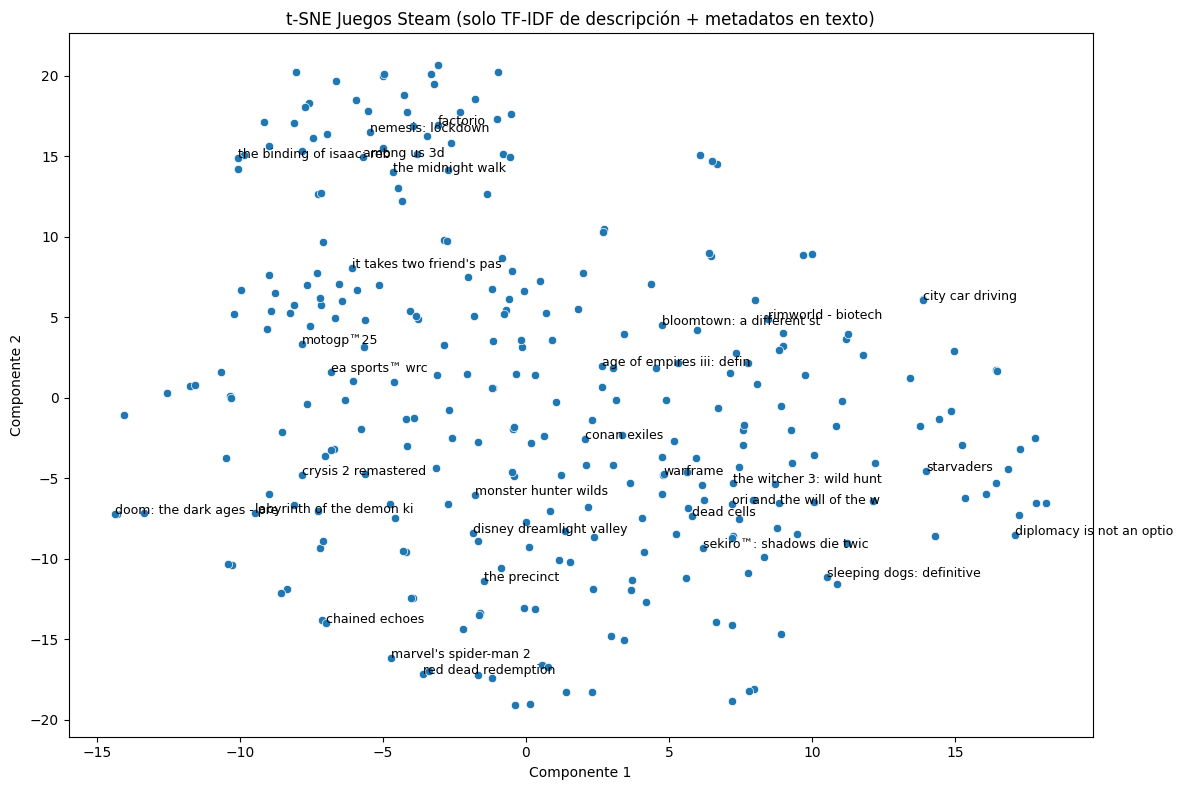

In [18]:
# Selección de muestra para visualización
sample_size = 300
np.random.seed(42)
sample_indices = np.random.choice(tfidf_matrix.shape[0], size=sample_size, replace=False)

# Aplicar t-SNE sobre los vectores TF-IDF
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_tsne = tsne.fit_transform(tfidf_matrix[sample_indices].toarray())

# Preparar títulos truncados para visualización
sample_titles = juegos_df.iloc[sample_indices]['game_title'].fillna("Desconocido").str[:25]

# Visualizar con seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_tsne[:, 0], y=reduced_tsne[:, 1])
for i in range(0, sample_size, 10):  # etiquetas cada 30 puntos
    plt.text(reduced_tsne[i, 0], reduced_tsne[i, 1], sample_titles.iloc[i], fontsize=9)

plt.title("t-SNE Juegos Steam (solo TF-IDF de descripción + metadatos en texto)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.tight_layout()
plt.show()

### Enfoque empleando el texto, las categorías y los géneros por separado

In [25]:
# 1. TF-IDF sobre 'clean_text'
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_es = stopwords.words('spanish')

vectorizer_text = TfidfVectorizer(stop_words=stopwords_es, max_features=5000)
tfidf_text = vectorizer_text.fit_transform(juegos_df['clean_short_text'])

# 2. One-hot encoding para 'genres' y 'categories'
mlb_genres = MultiLabelBinarizer()
mlb_categories = MultiLabelBinarizer()

# Convierte de string a listas
juegos_df.loc[:, 'genres_list'] = juegos_df['genres'].apply(lambda x: eval(x) if pd.notnull(x) else [])
juegos_df.loc[:, 'categories_list'] = juegos_df['categories'].apply(lambda x: eval(x) if pd.notnull(x) else [])


genres_encoded = mlb_genres.fit_transform(juegos_df['genres_list'])
categories_encoded = mlb_categories.fit_transform(juegos_df['categories_list'])

from sklearn.preprocessing import Normalizer
normalizer = Normalizer(norm='l2')

tfidf_text = normalizer.fit_transform(tfidf_text)
genres_encoded = normalizer.fit_transform(genres_encoded)
categories_encoded = normalizer.fit_transform(categories_encoded)

weight_genres = 4   # Máxima prioridad: refleja la esencia del juego.
weight_categories = 2  # Prioridad media: atributos secundarios.
weight_tfidf = 1     # Prioridad baja: texto puede ser ruidoso.


# 3. Concatenar los vectores
from scipy.sparse import csr_matrix
combined_features = hstack([
    tfidf_text * weight_tfidf,
    csr_matrix(genres_encoded) * weight_genres,
    csr_matrix(categories_encoded) * weight_categories
])

# 4. Calcular similitud coseno
similitud_coseno = cosine_similarity(combined_features, combined_features)
# Crear serie índice por nombre del juego
indices_juegos = pd.Series(juegos_df.index, index=juegos_df['game_title'].str.lower().fillna("desconocido")).drop_duplicates()

# Función de recomendación actualizada
def recomendar_juegos_combinado(nombre_juego, top_n=5):
    nombre_juego = nombre_juego.lower()
    if nombre_juego not in indices_juegos:
        return f"No se encontró el juego '{nombre_juego}'."
    
    idx = indices_juegos[nombre_juego]
    similitudes = list(enumerate(similitud_coseno[idx]))
    similitudes = sorted(similitudes, key=lambda x: x[1], reverse=True)[1:top_n+1]
    juegos_recomendados = [juegos_df.iloc[i[0]]['game_title'] for i in similitudes]
    
    return juegos_recomendados

# Ejemplo de prueba
print(recomendar_juegos_combinado("PUBG: BATTLEGROUNDS"))


['lost ark', 'throne and liberty', 'naraka: bladepoint', 'apex legends™', 'destiny 2']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noelg02/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg

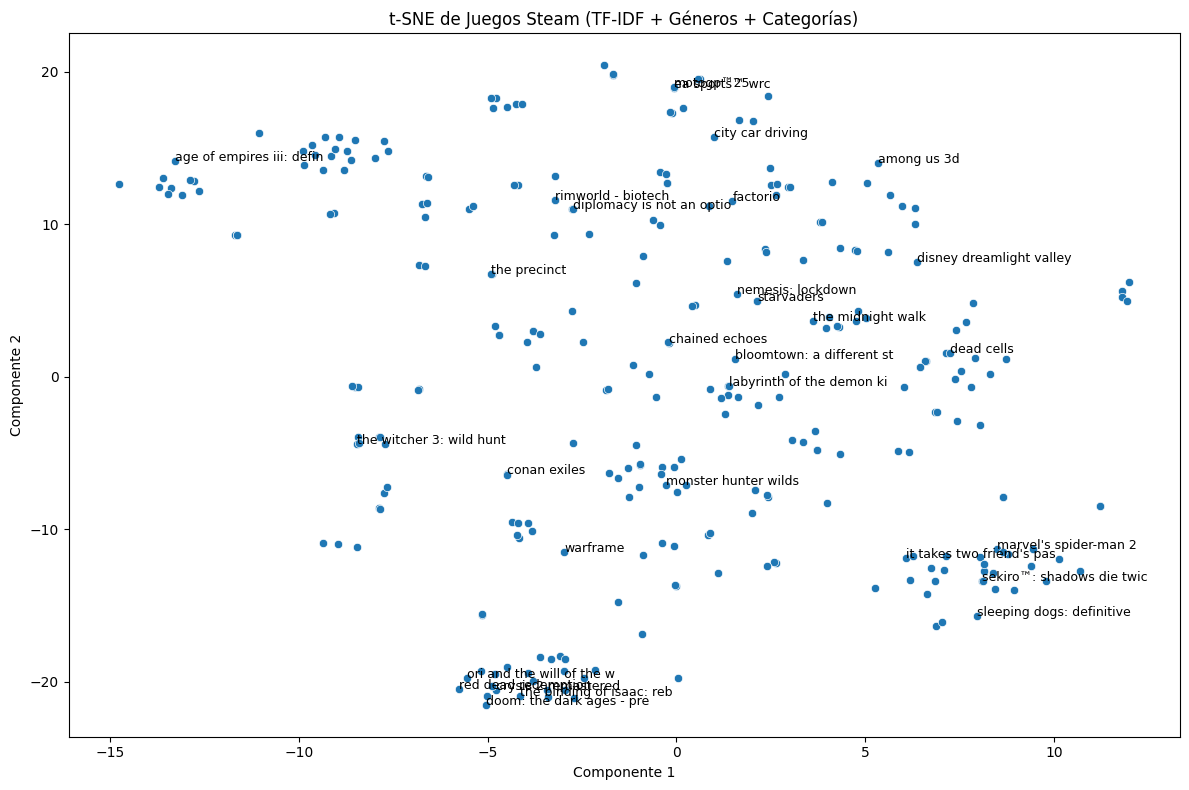

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reducimos la dimensionalidad con t-SNE
sample_size = 300  # puedes ajustarlo para más juegos
np.random.seed(42)
sample_indices = np.random.choice(combined_features.shape[0], size=sample_size, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_tsne = tsne.fit_transform(combined_features[sample_indices].toarray())

# Preparamos los títulos recortados para visualización
sample_titles = juegos_df.iloc[sample_indices]['game_title'].fillna("Desconocido").str[:25]

# Visualización
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_tsne[:, 0], y=reduced_tsne[:, 1])
for i in range(0, sample_size, 10):  # muestra algunos nombres cada N puntos
    plt.text(reduced_tsne[i, 0], reduced_tsne[i, 1], sample_titles.iloc[i], fontsize=9)
plt.title("t-SNE de Juegos Steam (TF-IDF + Géneros + Categorías)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.tight_layout()
plt.show()


Como se ve para el texto limpio la segunda estrategia (TF-IDF + Géneros + Categorías) parece más adecuada para un sistema de recomendación, dado que parece capturar una similitud semántica y de contexto mejor entre los juegos. Además, en el gráfico vemos agrupamientos más coherentes temáticamente, por lo que es probable que se geneneren recomendaciones más precisas.

## Alternativa al texto en crudo vamos a probar a emplear el texto lematizado con ambas técnicas.

### Enfoque con el texto concatenado con el género y las categorías con el texto lematizado

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_es = stopwords.words('spanish')
vectorizer = TfidfVectorizer(stop_words=stopwords_es, max_features=10000)
tfidf_matrix = vectorizer.fit_transform(juegos_df['texto_completo_lematizado'])

# Calcular similitud coseno
similitud_coseno = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Guardar nombres de los juegos (por índice)
indices_juegos = pd.Series(juegos_df.index, index=juegos_df['game_title'].fillna("Desconocido")).drop_duplicates()

# Función de recomendación
def recomendar_juegos(nombre_juego, top_n=5):
    nombre_juego = nombre_juego.lower()
    if nombre_juego not in indices_juegos:
        return f"No se encontró el juego '{nombre_juego}'."
    
    idx = indices_juegos[nombre_juego]
    similitudes = list(enumerate(similitud_coseno[idx]))
    similitudes = sorted(similitudes, key=lambda x: x[1], reverse=True)[1:top_n+1]
    juegos_recomendados = [juegos_df.iloc[i[0]]['game_title'] for i in similitudes]
    
    return juegos_recomendados

# Ejemplo
print(recomendar_juegos("PUBG: BATTLEGROUNDS"))

['warframe', 'war thunder', 'dead by daylight', 'terraria', 'world of tanks']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noelg02/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg

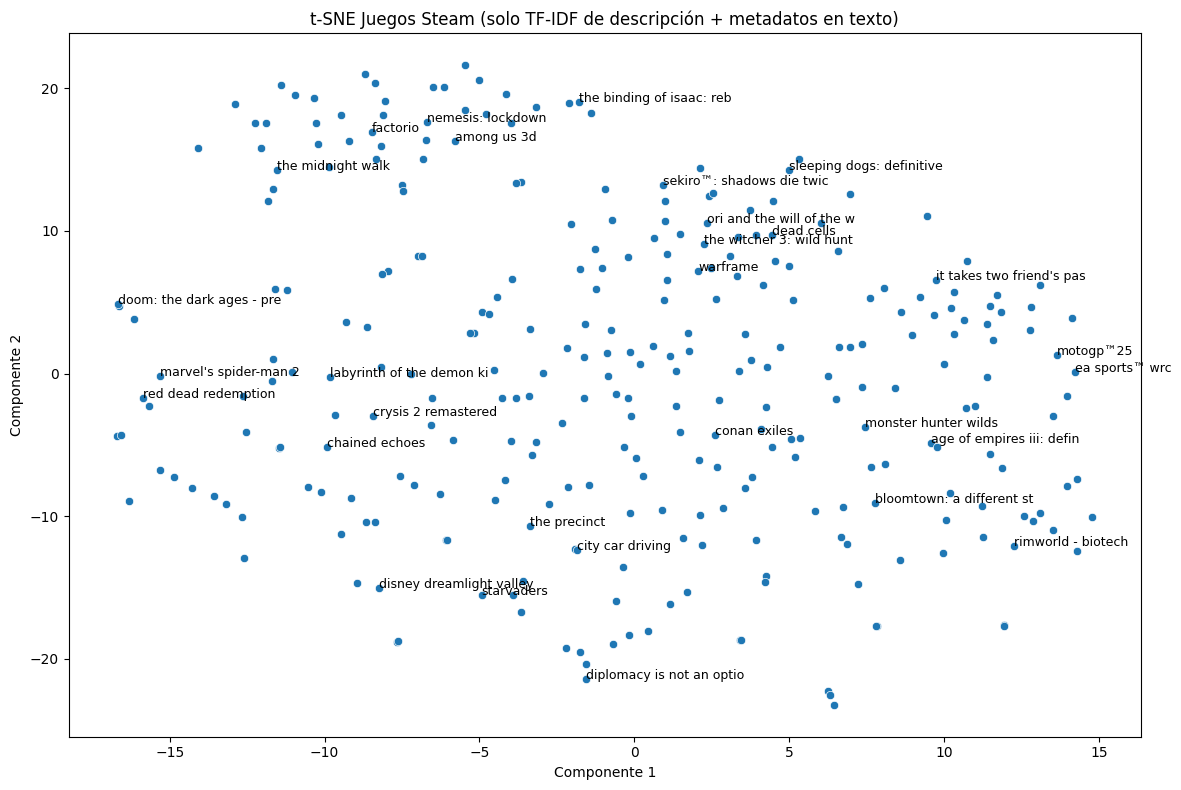

In [18]:
# Selección de muestra para visualización
sample_size = 300
np.random.seed(42)
sample_indices = np.random.choice(tfidf_matrix.shape[0], size=sample_size, replace=False)

# Aplicar t-SNE sobre los vectores TF-IDF
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_tsne = tsne.fit_transform(tfidf_matrix[sample_indices].toarray())

# Preparar títulos truncados para visualización
sample_titles = juegos_df.iloc[sample_indices]['game_title'].fillna("Desconocido").str[:25]

# Visualizar con seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_tsne[:, 0], y=reduced_tsne[:, 1])
for i in range(0, sample_size, 10):  # etiquetas cada 30 puntos
    plt.text(reduced_tsne[i, 0], reduced_tsne[i, 1], sample_titles.iloc[i], fontsize=9)

plt.title("t-SNE Juegos Steam (solo TF-IDF de descripción + metadatos en texto)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.tight_layout()
plt.show()

### Enfoque empleando el texto, las categorías y los géneros por separado pero con el texto lematizado

In [27]:
# 1. TF-IDF sobre 'clean_text'
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_es = stopwords.words('spanish')

vectorizer_text = TfidfVectorizer(stop_words=stopwords_es, max_features=5000)
tfidf_text = vectorizer_text.fit_transform(juegos_df['lemmatized_short_text'])

# 2. One-hot encoding para 'genres' y 'categories'
mlb_genres = MultiLabelBinarizer()
mlb_categories = MultiLabelBinarizer()

# Convierte de string a listas
juegos_df.loc[:, 'genres_list'] = juegos_df['genres'].apply(lambda x: eval(x) if pd.notnull(x) else [])
juegos_df.loc[:, 'categories_list'] = juegos_df['categories'].apply(lambda x: eval(x) if pd.notnull(x) else [])


genres_encoded = mlb_genres.fit_transform(juegos_df['genres_list'])
categories_encoded = mlb_categories.fit_transform(juegos_df['categories_list'])

tfidf_text = normalizer.fit_transform(tfidf_text)
genres_encoded = normalizer.fit_transform(genres_encoded)
categories_encoded = normalizer.fit_transform(categories_encoded)

weight_genres = 4    # Máxima prioridad: refleja la esencia del juego.
weight_categories = 2  # Prioridad media: atributos secundarios.
weight_tfidf = 1     # Prioridad baja: texto puede ser ruidoso.


# 3. Concatenar los vectores
from scipy.sparse import csr_matrix
combined_features = hstack([
    tfidf_text * weight_tfidf,
    csr_matrix(genres_encoded) * weight_genres,
    csr_matrix(categories_encoded) * weight_categories
])

# 4. Calcular similitud coseno
similitud_coseno = cosine_similarity(combined_features, combined_features)
# Crear serie índice por nombre del juego
indices_juegos = pd.Series(juegos_df.index, index=juegos_df['game_title'].str.lower().fillna("desconocido")).drop_duplicates()

# Función de recomendación actualizada
def recomendar_juegos_combinado(nombre_juego, top_n=5):
    nombre_juego = nombre_juego.lower()
    if nombre_juego not in indices_juegos:
        return f"No se encontró el juego '{nombre_juego}'."
    
    idx = indices_juegos[nombre_juego]
    similitudes = list(enumerate(similitud_coseno[idx]))
    similitudes = sorted(similitudes, key=lambda x: x[1], reverse=True)[1:top_n+1]
    juegos_recomendados = [juegos_df.iloc[i[0]]['game_title'] for i in similitudes]
    
    return juegos_recomendados

# Ejemplo de prueba
print(recomendar_juegos_combinado("PUBG: BATTLEGROUNDS"))


['lost ark', 'throne and liberty', 'apex legends™', 'naraka: bladepoint', 'destiny 2']


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noelg02/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg02/venvs/steam/lib/python3.12/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/noelg

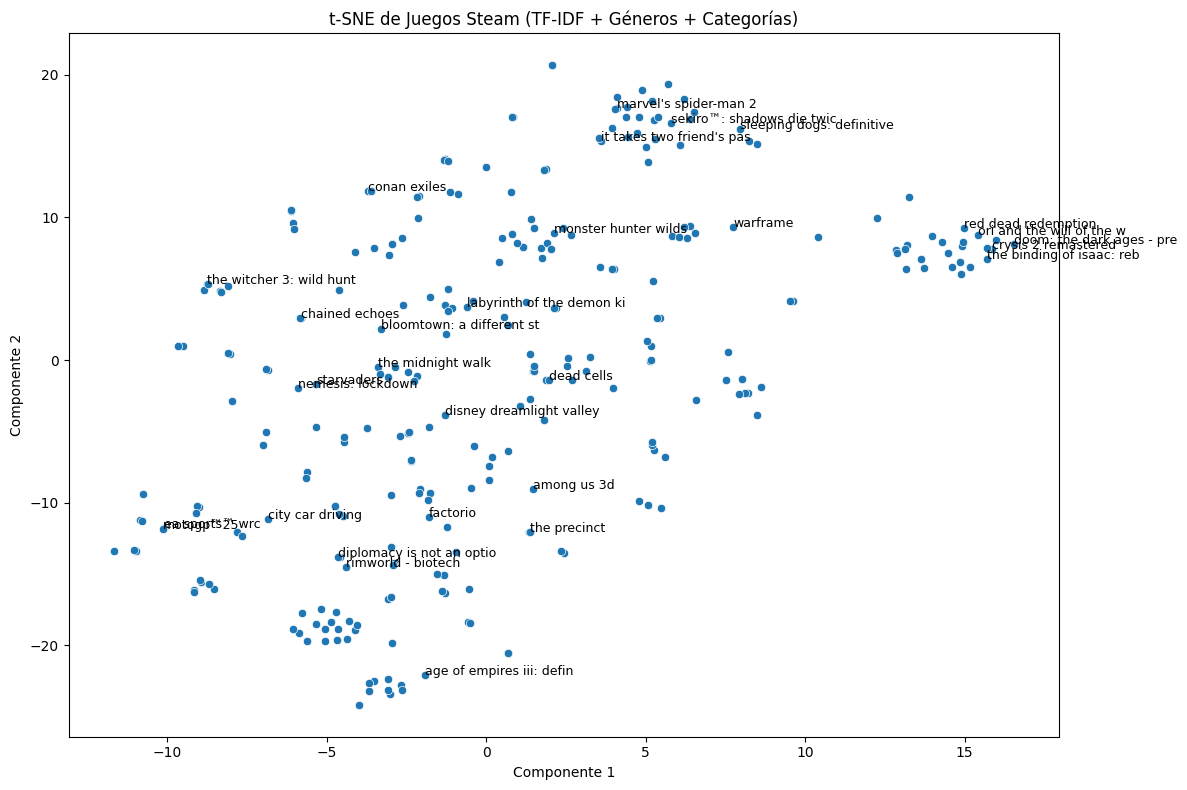

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reducimos la dimensionalidad con t-SNE
sample_size = 300  # puedes ajustarlo para más juegos
np.random.seed(42)
sample_indices = np.random.choice(combined_features.shape[0], size=sample_size, replace=False)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_tsne = tsne.fit_transform(combined_features[sample_indices].toarray())

# Preparamos los títulos recortados para visualización
sample_titles = juegos_df.iloc[sample_indices]['game_title'].fillna("Desconocido").str[:25]

# Visualización
plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_tsne[:, 0], y=reduced_tsne[:, 1])
for i in range(0, sample_size, 10):  # muestra algunos nombres cada N puntos
    plt.text(reduced_tsne[i, 0], reduced_tsne[i, 1], sample_titles.iloc[i], fontsize=9)
plt.title("t-SNE de Juegos Steam (TF-IDF + Géneros + Categorías)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.tight_layout()
plt.show()


Como vemos el que tiene el texto lematizado con los géneros y categorías por separado es el que mejor nos ha funcionado de los 3 al mostrar ls clusters de manera más precisa.

## Finalmente guardamos todos los archivos necesarios

In [29]:
import pickle
import pandas as pd

# Guarda el DataFrame de juegos
juegos_df.to_csv("juegos_con_vectores.csv", index=False)

# Guarda la matriz dispersa de características combinadas
with open("combined_features.pkl", "wb") as f:
    pickle.dump(combined_features, f)

# Guarda la matriz de similitud coseno (puede ocupar bastante espacio)
with open("similitud_combinada.pkl", "wb") as f:
    pickle.dump(similitud_coseno, f)

# Creación de la app de streamlit con el chatbot

Debido a como funciona streamlit ha sido necesario enviar el código de esta parte a un archivo .py y para ejecutarlo se debe de escribir por terminal streamlit run streamlit_recomendador.py dado que es una ejecución especial de estas apps. Esto te abrirá la app en el navegador donde ya podrás disfrutar de las recomendaciones.